In [ ]:
!pip install tensorflow
!pip install pandas
!pip install numpy

In [63]:
from geneticalgorithm import geneticalgorithm as ga
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.models import model_from_json
from keras import backend as k

json_file = open('/content/model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("/content/model.h5")

def GA(population_size, mutation_probability, crossover_probability, parents_portion):
  def fitnessfunction(x):
      x= np.reshape(x, ( 1 ,x.shape[0]))
      output = loaded_model.predict(x)
      output = - output
      return output

  varbound=np.array([[5, 8], [60, 60.1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1], [0,1]])
#  varbound=np.array([[5, 8], [60, 60.1], [0,2], [0,1], [0,2]])
#  vartype=np.array([['int'],['int'],['int'],['int'],['int']])
  vartype=np.array([['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int'],['int']])

  algorithm_param = {'max_num_iteration': None,\
                     'population_size': population_size,\
                    'crossover_probability':crossover_probability,\
                    'mutation_probability':mutation_probability,\
                    'elit_ratio': 0.01,\
                    'crossover_probability':crossover_probability,\
                    'parents_portion':parents_portion,\
                    'crossover_type':'uniform',\
                    'max_iteration_without_improv':None}

  model=geneticalgorithm(function=fitnessfunction,dimension=10,variable_type_mixed=vartype,variable_boundaries=varbound,algorithm_parameters=algorithm_param)

  model.run()

In [64]:
population_size = [100]
mutation_probability = [0.1]
crossover_probability = [0.5]
parents_portion = [0.3]

population_size: 100
mutation_probability: 0.1
crossover_probability: 0.5
parents_portion: 0.3
 The best solution found:
 [ 5. 60.  0.  0.  1.  0.  1.  0.  1.  0.]

 Objective function:
 -73.95179748535156


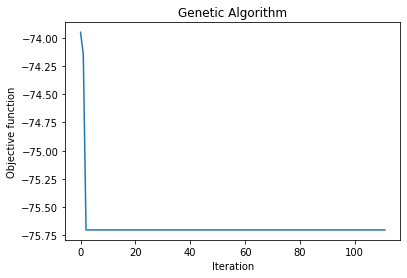

In [65]:
for i in population_size:
  for j in mutation_probability:
    for k in crossover_probability:
      for l in parents_portion:
        print("population_size: %r"%i)
        print("mutation_probability: %r"%j)
        print("crossover_probability: %r"%k)
        print("parents_portion: %r"%l)
        GA(i, j, k, l)

In [37]:
#x = [8, 1, 0, 2, 49.91]
x = [5, 60, 0, 0, 1, 0, 1, 0, 1, 0]
#x = [8, 49.91, 0, 1, 0, 1, 0, 0, 0, 1]
x =np.array(x)
x= np.reshape(x, ( 1 ,x.shape[0]))
output = loaded_model.predict(x)
print(output[0][0])

73.9518
